# Research on the historical data on game sales

The online store Ice, which sells video games all over the world. User and expert reviews, genres, platforms (e.g. Xbox or PlayStation), and historical data on game sales are available from open sources. 

We'll identify patterns that determine whether a game succeeds or not. This will allow us to spot potential big winners and plan advertising campaigns. In front of us is data going back to 2016. Let’s imagine that it’s December 2016 and we’re planning a campaign for 2017.

### Step 1. Openning the data file and studying the general information. 

In [1]:
#Let’s read a table 'games' from the csv file, save it and check what we have there.
import re
import pandas as pd
import numpy as np 
import math as mt
from math import factorial
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats as st
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt


games = pd.read_csv('/datasets/games.csv', sep=',')
games.info()
games.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [2]:
#display(games)

### Conclusion

There is a data set saved as a variable **games**. Its total length is 16715 rows, every row represents one game and its characteristics in columns: Name, Platform, Year_of_Release, Genre, NA_sales - North American sales in USD million, EU_sales - sales in Europe in USD million, JP_sales - sales in Japan in USD million, Other_sales - sales in other countries in USD million, Critic_Score - expert reviews (maximum of 100), User_Score - users reviews (maximum of 10), Rating - ESRB (the Entertainment Software Rating Board evaluates a game's content and assigns an age rating such as Teen or Mature).

### Step 2. Data preprocessing

In [3]:
#Let's check what data types we have in our tables and convert to the necessary types if needed (from info method above):
#it looks like User_Score is saved as string but initially should contain integer or float
#let's check what values do we have there with value_counts method:
games['User_Score'].value_counts()

#there are 2424 entries with 'tbd' value (to be determined), let's replace it with null and then all to float:
games['User_Score'] = games['User_Score'].replace('tbd', 'NaN')
games['User_Score'] = pd.to_numeric(games['User_Score'], errors='coerce')

#games['User_Score'].value_counts()

games.info()
games.sample(10)
games.shape[0]
games.describe(include=['object'])
#games.nlargest(5,['na_sales'])
#games.rating.unique()
#games.rating.isnull().sum()
#games.rating.notnull().sum()
#games.user_score.apply(type).unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         7590 non-null float64
Rating             9949 non-null object
dtypes: float64(7), object(4)
memory usage: 1.4+ MB


,Name,Platform,Genre,Rating
count,16713,16715,16713,9949
unique,11559,31,12,8
top,Need for Speed: Most Wanted,PS2,Action,E
freq,12,2161,3369,3990


In [4]:
#let's replace the column names (make them lowercase):
games.columns = [
    'name','platform','year_of_release','genre','na_sales','eu_sales',
    'jp_sales','other_sales','critic_score','user_score','rating'
]

In [5]:
#Let's check data quality by counting null values

print(games.isnull().sum())

#there results are as follows:
#names - 2 null values: suggested to delete (drop) the whole row as this is the key (mandatory) element
#year_of_release - there are 269 null values (about 1% of 16000 entries), so we can delete those rows as well
games = games[games['year_of_release'].notna()]
games = games[games['name'].notna()]

#critic_score, user_score and rating - leave it as is in order not to impact negative rating with 0

#games['year_of_release'].value_counts()
#print(games)
#games.info()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64


In [6]:
#Let's calculate the total sales (the sum of sales in all regions) 
#for each game and put these values in a separate column
games['total_sales']=games[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)
games.reset_index()
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


### Conclusion

As part of the data preprocessing, we 
- converted the data to the necessary types as follows: 
    - user_score: once replaced value 'tbd' with null (to keep rating clean), converted it from str to float
- replaced the column names making them all using lowercase letters
- droped rows that had missing values for 'name' and 'year_of_release' (supposing this is mandatory fields in our research)
- created 'total_sales' column that summs up 'na_sales', 'eu_sales', 'jp_sales' and 'other_sales'.

As a result our table reduced from 16715 to 16444 entries (less than 2% difference).

In [7]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null float64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         7463 non-null float64
rating             9768 non-null object
total_sales        16444 non-null float64
dtypes: float64(8), object(4)
memory usage: 1.6+ MB


### Step 3. Analyzing the data


#### all data analysis (1980-2016):

In [8]:
#let's look at how many games were released in different years
df = games[
    ['year_of_release','name']].groupby('year_of_release').count().sort_values(by='year_of_release').reset_index()


In [9]:
df=df[df['year_of_release']!=0]
df.head()

,year_of_release,name
0,1980.0,9
1,1981.0,46
2,1982.0,36
3,1983.0,17
4,1984.0,14


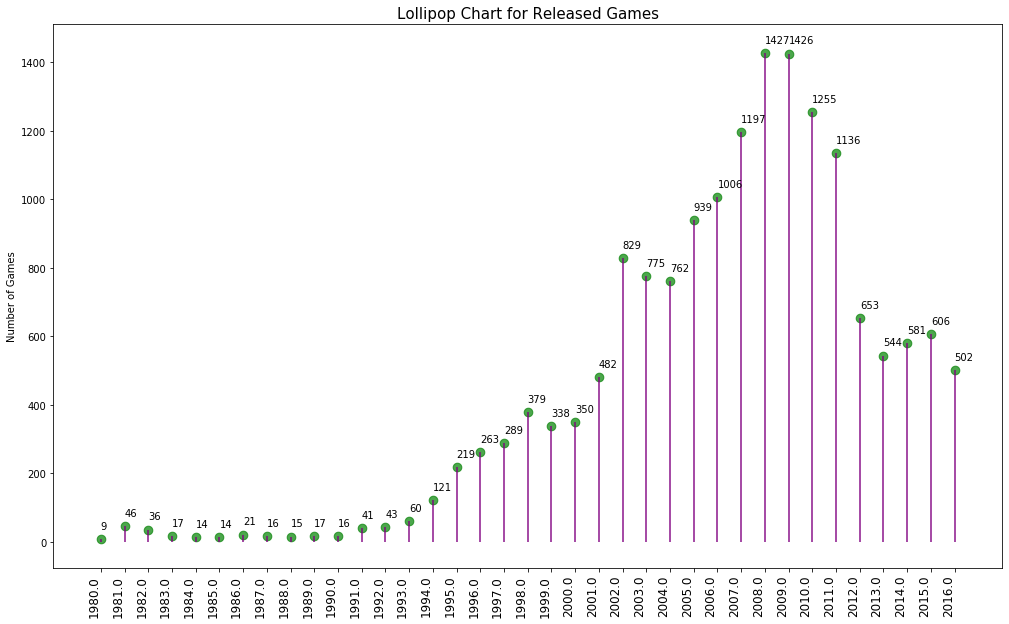

In [10]:
fig,ax=plt.subplots(figsize=(17,10))
ax.vlines(x=df.year_of_release, ymin=0, ymax=df.name, color='purple', alpha=0.7, linewidth=2)
ax.scatter(x=df.year_of_release, y=df.name, s=75, color='green', alpha=0.7)

ax.set_title('Lollipop Chart for Released Games', fontdict={'size':15})
ax.set_ylabel('Number of Games')
ax.set_xticks(df.year_of_release)
ax.set_xticklabels(df.year_of_release, rotation=90, fontdict={'horizontalalignment':'right','size':12})

for row in df.itertuples():
    ax.text(row.year_of_release, row.name+30, s=round(row.name, 2))
    

#As a result of our chart, we can see that 2008 and 2009 were years when 1427 and 1426 games were released (max amount).
#We can see that the raise in games were after 1995, when personal computers were becoming more and more popular.
#Then after the economic crisis in 2009 the trend started to go down staying between 500-650 releases per year.

In [11]:
#Let's look at how sales varied from platform to platform. 
#Let's choose the platforms with the greatest total sales and build a distribution based on data for each year. 

platform = games[
    ['platform','year_of_release','total_sales']].groupby(['year_of_release','platform']).sum().sort_values(by='total_sales').reset_index()
platform.tail()

#We can see that the grates total sales were reached in 2004 PS2 platform, then Wii in 2009 and 3rd and 4th place 
#is again with PS2 in 2002 and 2003 

,year_of_release,platform,total_sales
233,2008.0,Wii,171.32
234,2003.0,PS2,184.31
235,2002.0,PS2,205.38
236,2009.0,Wii,206.97
237,2004.0,PS2,211.81


In [12]:
ordered=platform.groupby(['platform'])['total_sales'].sum().sort_values().reset_index()['platform']

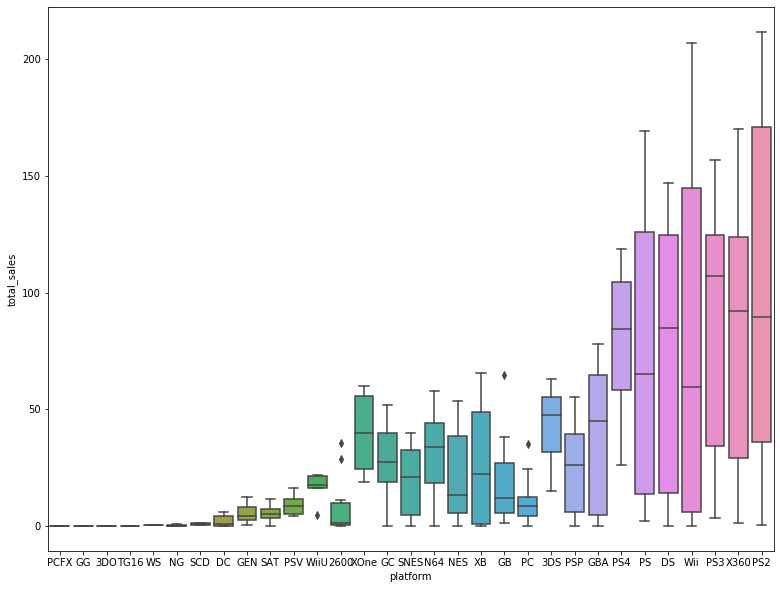

In [13]:
plt.figure(figsize=(13,10))
sns.boxplot(x='platform',y='total_sales',data=platform, order=ordered)

#As per our graph we can see that PS2 is our leader in sales, then X360 and PS3.

In [14]:
#Then, we'll find platforms that used to be popular but now have zero sales. 
df_tree=games[['platform','total_sales']].groupby('platform').sum().sort_values(by='total_sales').reset_index()
df_tree['sales_z'] = (df_tree['total_sales']-df_tree['total_sales'].mean())/platform['total_sales'].std()
df_tree.tail()

,platform,total_sales,sales_z
26,DS,802.78,10.690966
27,Wii,891.18,12.513880
28,PS3,931.34,13.342027
29,X360,961.24,13.958601
30,PS2,1233.56,19.574165


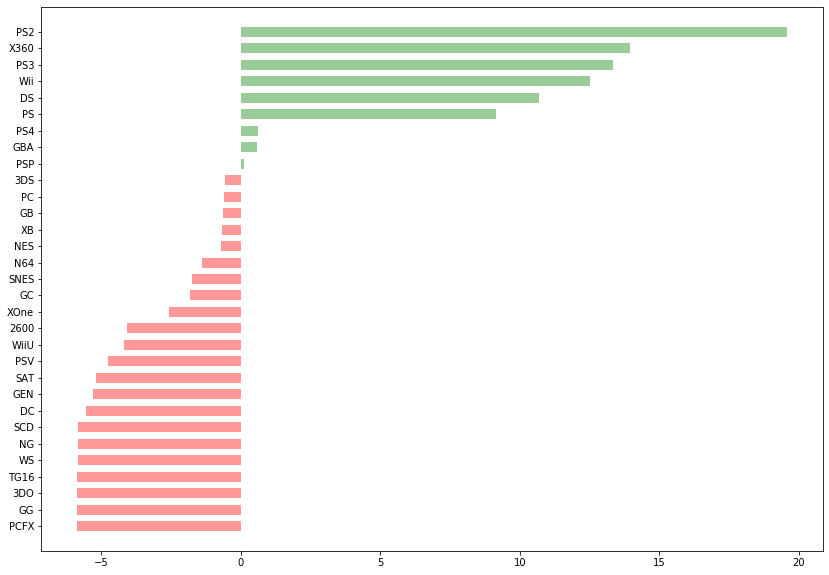

In [15]:
df_tree['colors']=['red' if  x<0 else 'green' for x in df_tree['sales_z']]
df_tree.head()

plt.figure(figsize=(14,10))
plt.hlines(y=df_tree.platform, xmin = 0, xmax=df_tree.sales_z, color=df_tree.colors, alpha=0.4,linewidth=10)

#Among those platforms that used to be popular and now not - PCFX, GG and 3D0 and more.

In [16]:
platform.head()

,year_of_release,platform,total_sales
0,2007.0,DC,0.02
1,1994.0,3DO,0.02
2,1985.0,DS,0.02
3,1988.0,PC,0.03
4,1996.0,PCFX,0.03


In [17]:
#Let's find out how long does it generally take for new platforms to appear and old ones to fade
#note: there are 31 platforms 

appear_fade=games.pivot_table(index='year_of_release', columns='platform', values='total_sales',aggfunc=sum, fill_value=0)
appear_fade.head()

platform,2600,3DO,3DS,DC,DS,GB,GBA,GC,GEN,GG,...,SAT,SCD,SNES,TG16,WS,Wii,WiiU,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,,,,,,,,
1980.0,11.38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1981.0,35.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1982.0,28.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1983.0,5.84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984.0,0.27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
appear_fade.shift(+1).head()

platform,2600,3DO,3DS,DC,DS,GB,GBA,GC,GEN,GG,...,SAT,SCD,SNES,TG16,WS,Wii,WiiU,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,,,,,,,,
1980.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981.0,11.38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1982.0,35.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1983.0,28.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984.0,5.84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
appear_fade.shift(+1,axis=1).head()

platform,2600,3DO,3DS,DC,DS,GB,GBA,GC,GEN,GG,...,SAT,SCD,SNES,TG16,WS,Wii,WiiU,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,,,,,,,,
1980.0,NaN,11.38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1981.0,NaN,35.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1982.0,NaN,28.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1983.0,NaN,5.84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984.0,NaN,0.27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
dynamics=appear_fade-appear_fade.shift(+1)

In [21]:
dynamics.T

year_of_release,1980.0,1981.0,1982.0,1983.0,1984.0,1985.0,1986.0,1987.0,1988.0,1989.0,...,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0
platform,,,,,,,,,,,,,,,,,,,,,
2600,NaN,24.3,-6.8,-23.04,-5.57,0.18,0.22,1.27,-1.20,-0.11,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3DO,NaN,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3DS,NaN,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,63.20,-11.84,5.21,-12.81,-15.98,-12.64
DC,NaN,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.02,0.02,-0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00
DS,NaN,0.0,0.0,0.00,0.00,0.02,-0.02,0.00,0.00,0.00,...,27.13,-1.63,-25.77,-34.52,-58.84,-15.17,-9.47,-1.54,0.00,0.00
GB,NaN,0.0,0.0,0.00,0.00,0.00,0.00,0.00,1.43,63.54,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
GBA,NaN,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,-1.88,-3.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
GC,NaN,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,-10.99,-0.27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
GEN,NaN,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


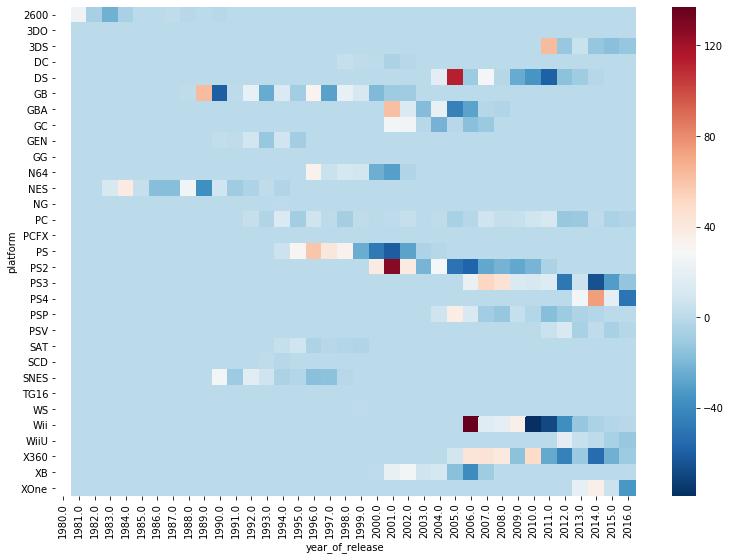

In [22]:
plt.figure(figsize=(13,9))
sns.heatmap(dynamics.T, cmap='RdBu_r')

#As per the below map, we can see that it takes 1 or 2 years to appear for new platforms 
#and up to 10 years to fade for the old ones.

#### filtered data analysis (2000 to 2016):

In [23]:
#Let's determine that we take data from 2000
#based on this data we'll build a prognosis for 2017
new_data = games.query('year_of_release >=2000')

#we'll have here 14470 entries

In [24]:
#let's check for the new data which platforms are leading in sales
new_platform = new_data[['platform','year_of_release','total_sales']].groupby(['year_of_release','platform']).sum().sort_values(by='total_sales').reset_index()
new_platform.tail()
#We can see that the grates total sales were reached in 2004 PS2 platform, then Wii in 2009 and 3rd and 4th place 
#is again with PS2 in 2002 and 2003 

,year_of_release,platform,total_sales
145,2008.0,Wii,171.32
146,2003.0,PS2,184.31
147,2002.0,PS2,205.38
148,2009.0,Wii,206.97
149,2004.0,PS2,211.81


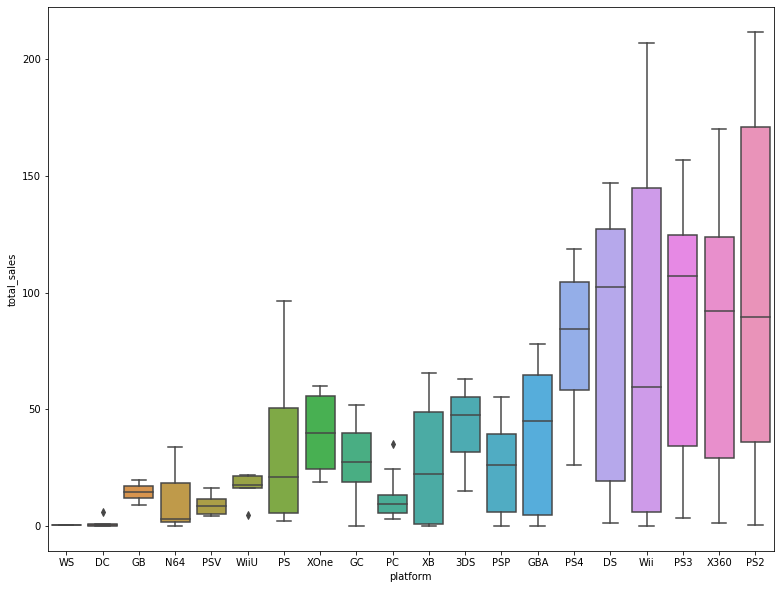

In [25]:
#Now let's build a box plot for the global sales of all games, broken down by platform. 

new_ordered=new_platform.groupby(['platform'])['total_sales'].sum().sort_values().reset_index()['platform']
plt.figure(figsize=(13,10))
sns.boxplot(x='platform',y='total_sales',data=new_platform, order=new_ordered)

#As per our graph we can see that PS2 is our leader in sales, then X360 and PS3.
#The differences in sales is not significant between PS2 and Wii, for example, but their median are different.


In [26]:
new_platform.groupby(['platform'])['total_sales'].mean().sort_values().reset_index()
#Interesting that the average sales in X360, PS3, Wii, PS4 and DS are very similar, 
#while gaps are much higher with the leader PS2 and other platforms with lower sales.

,platform,total_sales
0,WS,0.480000
1,DC,1.482000
2,PSV,8.968333
3,PC,12.101176
4,N64,12.433333
5,GB,14.500000
6,WiiU,16.438000
7,PSP,24.127500
8,XB,27.952222
9,GC,28.104286


In [27]:
#Let's check which ones are growing or shrinking (with heatmap diagram) 

new_data=new_data.pivot_table(index='year_of_release', columns='platform', values='total_sales',aggfunc=sum, fill_value=0)
new_data.tail()

platform,3DS,DC,DS,GB,GBA,GC,N64,PC,PS,PS2,PS3,PS4,PSP,PSV,WS,Wii,WiiU,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,,,,,,,
2012.0,51.36,0.0,11.01,0.0,0.0,0.0,0.0,23.22,0.0,0.0,107.36,0.00,7.69,16.19,0.0,21.71,17.56,99.74,0.0,0.00
2013.0,56.57,0.0,1.54,0.0,0.0,0.0,0.0,12.38,0.0,0.0,113.25,25.99,3.14,10.59,0.0,8.59,21.65,88.58,0.0,18.96
2014.0,43.76,0.0,0.00,0.0,0.0,0.0,0.0,13.28,0.0,0.0,47.76,100.00,0.24,11.90,0.0,3.75,22.03,34.74,0.0,54.07
2015.0,27.78,0.0,0.00,0.0,0.0,0.0,0.0,8.52,0.0,0.0,16.82,118.90,0.12,6.25,0.0,1.14,16.35,11.96,0.0,60.14
2016.0,15.14,0.0,0.00,0.0,0.0,0.0,0.0,5.25,0.0,0.0,3.60,69.25,0.00,4.25,0.0,0.18,4.60,1.52,0.0,26.15


In [28]:
new_data.shift(+1).head()

platform,3DS,DC,DS,GB,GBA,GC,N64,PC,PS,PS2,PS3,PS4,PSP,PSV,WS,Wii,WiiU,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,,,,,,,
2000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001.0,0.0,5.99,0.0,19.76,0.07,0.00,33.97,4.66,96.37,39.17,0.0,0.0,0.0,0.0,0.68,0.0,0.0,0.0,0.99,0.0
2002.0,0.0,1.07,0.0,9.24,61.53,26.34,3.25,5.47,35.59,166.43,0.0,0.0,0.0,0.0,0.28,0.0,0.0,0.0,22.26,0.0
2003.0,0.0,0.29,0.0,0.00,74.16,51.81,0.08,8.57,6.67,205.38,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,48.01,0.0
2004.0,0.0,0.00,0.0,0.00,56.67,50.61,0.00,8.84,2.07,184.31,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,55.04,0.0


In [29]:
new_data.shift(+1,axis=1).head()

platform,3DS,DC,DS,GB,GBA,GC,N64,PC,PS,PS2,PS3,PS4,PSP,PSV,WS,Wii,WiiU,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,,,,,,,
2000.0,NaN,0.0,5.99,0.00,19.76,0.07,0.00,33.97,4.66,96.37,39.17,0.0,0.0,0.00,0.0,0.68,0.0,0.0,0.0,0.99
2001.0,NaN,0.0,1.07,0.00,9.24,61.53,26.34,3.25,5.47,35.59,166.43,0.0,0.0,0.00,0.0,0.28,0.0,0.0,0.0,22.26
2002.0,NaN,0.0,0.29,0.00,0.00,74.16,51.81,0.08,8.57,6.67,205.38,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,48.01
2003.0,NaN,0.0,0.00,0.00,0.00,56.67,50.61,0.00,8.84,2.07,184.31,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,55.04
2004.0,NaN,0.0,0.00,17.27,0.00,77.91,28.82,0.00,10.39,0.00,211.81,0.0,0.0,7.06,0.0,0.00,0.0,0.0,0.0,65.42


In [30]:
new_dynamics=new_data-new_data.shift(+1)

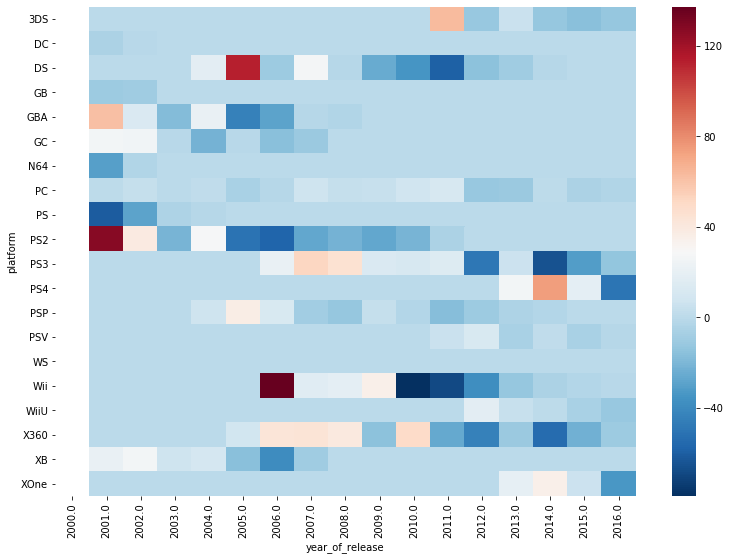

In [31]:
plt.figure(figsize=(13,9))
sns.heatmap(new_dynamics.T, cmap='RdBu_r')


In [32]:
#we can see that X360 and PS2 although were leaders in total_sales now are not that well
#Thus, our potentially profitable platforms would be PS4, XOne and 3DS.

In [33]:
#Let's take a look at how user and professional reviews affect sales for one popular platform - PS4 
#For that, we'll build a scatter plot and calculate the correlation between reviews and sales:
ps4 = games.query('platform == "PS4"')[
    ['year_of_release', 'total_sales','critic_score','user_score','rating']
].groupby('year_of_release').sum().sort_values(by='year_of_release').reset_index()

In [34]:
ps4.corr()


,year_of_release,total_sales,critic_score,user_score
year_of_release,1.000000,0.473145,0.974515,0.978946
total_sales,0.473145,1.000000,0.651649,0.633659
critic_score,0.974515,0.651649,1.000000,0.999715
user_score,0.978946,0.633659,0.999715,1.000000


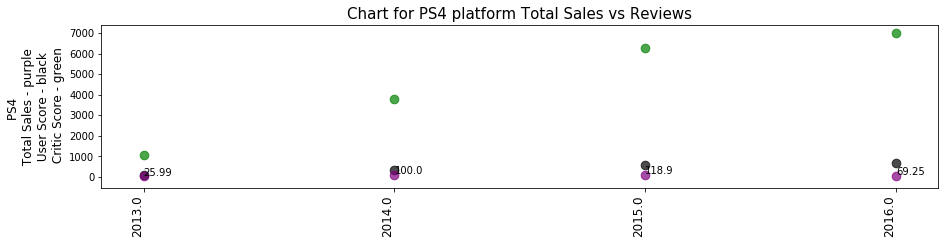

In [35]:
fig,ax=plt.subplots(figsize=(15,3))

ax.scatter(x=ps4.year_of_release, y=ps4.critic_score, s=75, color='green', alpha=0.7)
ax.scatter(x=ps4.year_of_release, y=ps4.user_score, s=75, color='black', alpha=0.7)
ax.scatter(x=ps4.year_of_release, y=ps4.total_sales, s=75, color='purple', alpha=0.7)

ax.set_title('Chart for PS4 platform Total Sales vs Reviews', fontdict={'size':15})
ax.set_ylabel('PS4 \n Total Sales - purple \n User Score - black \n Critic Score - green', fontdict={'size':12})
ax.set_xticks(ps4.year_of_release)
ax.set_xticklabels(ps4.year_of_release, rotation=90, fontdict={'horizontalalignment':'right','size':12})

for row in ps4.itertuples():
    ax.text(row.year_of_release, row.total_sales+30, s=round(row.total_sales, 2))
 

In [36]:
#We can see that User Score and Critic Score are growing with the total sales till 2015
# there is 60% of correlation, in 2016 both scores are still growing regardless drop in total sales
ps4

,year_of_release,total_sales,critic_score,user_score
0,2013.0,25.99,1064.0,81.9
1,2014.0,100.00,3803.0,350.5
2,2015.0,118.90,6276.0,607.6
3,2016.0,69.25,7024.0,694.3


In [37]:
#let's check now how games from PS4, are soled on other platforms:
ps4_games=games.query('platform == "PS4" & year_of_release >=2000')
ps4_games.drop_duplicates().reset_index()

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,31,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
1,42,Grand Theft Auto V,PS4,2014.0,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
2,77,FIFA 16,PS4,2015.0,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
3,87,Star Wars Battlefront (2015),PS4,2015.0,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98
4,92,Call of Duty: Advanced Warfare,PS4,2014.0,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,16500,Root Letter,PS4,2016.0,Adventure,0.00,0.00,0.01,0.00,69.0,7.5,NaN,0.01
388,16503,Shin Hayarigami 2,PS4,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
389,16526,Dungeons 2,PS4,2016.0,Role-Playing,0.01,0.00,0.00,0.00,61.0,7.9,T,0.01
390,16530,Carmageddon: Max Damage,PS4,2016.0,Action,0.01,0.00,0.00,0.00,51.0,5.5,M,0.01


In [38]:
stat_games_ps4 = games.where(games['name'].isin(ps4_games['name']), 'Others')


In [39]:
stat_games_ps4 = stat_games_ps4[stat_games_ps4['name']!="Others"]

In [40]:
stat_games_ps4.drop_duplicates().reset_index()


,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,21.05
1,23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,16.27
2,31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
3,42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62
4,60,Call of Duty: Ghosts,X360,2013,Shooter,6.73,2.56,0.04,0.91,73,2.6,M,10.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,16672,Metal Gear Solid V: The Definitive Experience,XOne,2016,Action,0.01,0,0,0,NaN,NaN,M,0.01
1172,16691,Dynasty Warriors: Eiketsuden,PS3,2016,Action,0,0,0.01,0,NaN,NaN,NaN,0.01
1173,16692,Metal Gear Solid V: Ground Zeroes,PC,2014,Action,0,0.01,0,0,80,7.6,M,0.01
1174,16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0,0,0.01,0,NaN,NaN,NaN,0.01


In [41]:
stat_games_ps4 = stat_games_ps4.pivot_table(
    index=('name','platform','year_of_release'), 
    values= ('critic_score','user_score','total_sales'), 
    aggfunc=['sum']
).drop_duplicates().reset_index()


In [42]:
#stat_games_ps4

In [43]:
stat_games_ps4.columns=['name','platform','year_of_release','sum_critic_score','sum_total_sales','sum_user_score']

In [44]:
#stat_games_ps4 

In [45]:
stat_games_ps4.nlargest(5,['sum_total_sales'])
#We can see that those games that are sold by PS4 also well sold by other platforms,
#for example in our top 5 sales we can see Grand Theft Auto V that had the largest total sales in 2013 by PS3 and X360
#platforms, where PS4 with this game only on the 4th place.

,name,platform,year_of_release,sum_critic_score,sum_total_sales,sum_user_score
327,Grand Theft Auto V,PS3,2013.0,97.0,21.05,8.2
329,Grand Theft Auto V,X360,2013.0,97.0,16.27,8.1
117,Call of Duty: Black Ops 3,PS4,2015.0,0.0,14.63,0.0
328,Grand Theft Auto V,PS4,2014.0,97.0,12.62,8.3
124,Call of Duty: Ghosts,X360,2013.0,73.0,10.24,2.6


In [46]:
#Now let's take a look at the general distribution of games by genre. 
#let's see what can we say about the most profitable genres (with high and low sales)

In [47]:
games_genre=games.query('year_of_release >= 2000').pivot_table(
    index=('genre','year_of_release'), 
    values= ('critic_score','user_score','total_sales'), 
    aggfunc=['sum']
).drop_duplicates().reset_index()

In [48]:
games_genre.columns=['genre','year_of_release','sum_critic_score','sum_total_sales','sum_user_score']

In [49]:
games_genre.nlargest(5,['sum_total_sales'])


,genre,year_of_release,sum_critic_score,sum_total_sales,sum_user_score
9,Action,2009.0,10520.0,137.69,1098.0
179,Sports,2009.0,5558.0,137.37,583.1
176,Sports,2006.0,6921.0,135.78,622.1
8,Action,2008.0,10335.0,134.96,1021.7
13,Action,2013.0,6126.0,122.51,651.9


In [50]:
games_genre.nsmallest(5,['sum_total_sales'])
#We can see that the most profitable genre is 'action' and 'sport' in 2006, 2009 and 2008
#while the list profitable are 'puzzle' and 'strategy' in 2013, 2014 and 2016

,genre,year_of_release,sum_critic_score,sum_total_sales,sum_user_score
101,Puzzle,2016.0,0.0,0.01,0.0
100,Puzzle,2015.0,228.0,0.71,23.3
98,Puzzle,2013.0,220.0,0.96,20.4
201,Strategy,2014.0,161.0,0.98,13.6
203,Strategy,2016.0,669.0,1.13,59.8


### Conclusion

As part of out analysis, we took a look at how many ** games were released in different years**. Based on our chart, we found that 2008 and 2009 were years when most games were released (1427 and 1426 games accordingly).The main raise in games was after 1995 (when every year number of games almost doubled), most likely it was related to the raise in personal computers consumption. Then, after the economic crisis of 2009, the trend started to go down staying between 500-650 released games per year.

Another analysis was checking how **sales varied from platform to platform**.  We saw that the grates total sales were reached in 2004 by PS2 platform, then 2nd place was with Wii platform in 2009, then PS2 again for the 3rd and 4th position in 2002 and 2003. In absolute numbers, for the whole period from 1980 to 2016, PS2 platform was our leader in sales, followed by X360 and PS3.

Among **platforms that used to be popular but now have zero sales** there are PCFX, GG and 3D0 and other platforms (they hold sometimes only 1-2 years).

Next question that we studied was: how long does it generally take for **new platforms to appear and old ones to fade**. Thus, in general, it takes 1 or 2 years to appear for new platforms and up to 10 years to fade for the old ones (note: there are 31 platforms in our research).

**Then our analysis was built upon games released after year 2000** (we had here 14470 entries). We checked for the new data which platforms were leading in sales and came to the same conclusions as above: the grates total sales were reached in 2004 by PS2 platform, then 2nd place was with Wii platform in 2009, then PS2 again for the 3rd and 4th position in 2002 and 2003.

Regarding the **global sales of all games, broken down by platform**, PS2 is our leader in sales, then X360 and PS3 platform. The differences in sales is not significant between PS2 and Wii, for example, but their medians are different. Interesting, that the average sales in X360, PS3, Wii, PS4 and DS are very similar, while gaps are much higher with the leader PS2 and other platforms with lower sales.

When checking which platforms are growing or shrinking we saw that X360 and PS2 although were leaders in total sales, are not feeling that well in 2016. Thus, we chose that our **potentially profitable platforms in 2017 would be PS4, XOne and 3DS**.

While checking, how **user and professional reviews affect sales for one popular platform - PS4**, we saw user score and critic score were growing with the total sales till 2015 (there is 60% of correlation), while in 2016 both scores are still growing regardless some drop in total sales.

Then, we checked now how **games from PS4, are soled on other platforms**: those games that are sold by PS4 also well sold by other platforms, for example in our top 5 sales we saw ‘Grand Theft Auto V’ game that had the largest total sales in 2013 by PS3 and X360 platforms, where total sales of PS4 with this game remained only on the 4th place.

As the **general distribution of games by genre** we checked the most profitable genres (with high and low sales). Thus, the most profitable genre was 'action' and 'sport' in 2006, 2009 and 2008, while the list profitable were 'puzzle' and 'strategy' in 2013, 2014 and 2016.

### Step 4. Creating a user profile for each region

In [51]:
#for each region (NA, EU, JP) we'll create a user profile in order to dertermine :

In [52]:
#* The top five genres:

region_games_genre=games.query('year_of_release >= 2000').pivot_table(
    index=('genre','year_of_release'), 
    values= ('na_sales','eu_sales','jp_sales','other_sales'), 
    aggfunc=['sum']
).drop_duplicates().reset_index()

In [53]:
region_games_genre.columns=['genre','year_of_release','sum_eu_sales','sum_jp_sales','sum_na_sales','sum_other_sales']

In [54]:
region_games_genre.nlargest(10,['sum_jp_sales'])

#While we check top 5 genre we can see the partition as follows:
# in Europe: #1, #3 and #5 'action' in 2013 (43M$), 2012 (41M$), 2014 (40M$); #2 and #4 'sports' 
# in 2009 (42M$), 2006 (40M$)

# in Japan: #1-#5 'Role-Playing' in 2010 (24M$), 2013 (20M$), 2006 (20M$), 2014 (18M$), 2008 (18M$)

# in North America: #2, #3 and #5 'action' in 2008 (72M$), 2009 (71M$), 2010 (60M$); #1 and #4 'sports' 
# in 2006 (73M$), 2009 (71M$)

# in other countries: #1 - #4 'action' in 2008 (18M$), 2009 (16M$), 2004 (16M$), 2007 (15M$); #5 'sports' 
# in 2009 (15M$)

,genre,year_of_release,sum_eu_sales,sum_jp_sales,sum_na_sales,sum_other_sales
129,Role-Playing,2010.0,13.18,23.67,28.27,4.53
132,Role-Playing,2013.0,8.80,19.88,12.93,2.84
125,Role-Playing,2006.0,7.95,19.83,24.22,5.37
133,Role-Playing,2014.0,10.96,17.75,13.65,3.26
127,Role-Playing,2008.0,10.90,17.51,24.98,5.59
128,Role-Playing,2009.0,8.08,17.07,18.78,3.38
15,Action,2015.0,24.14,15.98,24.39,7.51
119,Role-Playing,2000.0,4.21,15.80,7.20,1.84
57,Misc,2006.0,19.26,15.74,25.90,6.07
130,Role-Playing,2011.0,13.77,14.43,19.78,4.85


In [55]:
#* The top five platforms:

region_games_platform=games.query('year_of_release >= 2000').pivot_table(
    index=('platform','year_of_release'), 
    values= ('na_sales','eu_sales','jp_sales','other_sales'), 
    aggfunc=['sum']
).drop_duplicates().reset_index()

In [56]:
region_games_platform.columns=['platform','year_of_release','sum_eu_sales','sum_jp_sales','sum_na_sales','sum_other_sales']

In [57]:
region_games_platform.nlargest(10,['sum_eu_sales'])
#While we check top 5 platforms we can see the partition as follows:
# in Europe: #1, #2 and #5 'PS2' in 2002 (65M$), 2003 (61M$), 2004 (56M$); #3 'Wii' in 2009 (60M$); #4 'PS3' 
# in 2011 (56M$)

# in Japan: #1-#5 'DS' in 2006 (40M$), 2005 (30M$), 2007 (27M$), 2009 (24M$), 2008 (24M$)

# in North America: #1, #3 'Wii' in 2009 (115M$), 2008 (97M$); #2 'X360' in 2010 (107M$); #4, #5 'PS2' 
# in 2004 (97M$), 2002 (97M$)

# in other countries: #1 - #3 - 'PS2' in 2004 (40M$), 2007 (24M$), 2002 (22M$); #4 and #5 'PS3' 
# in 2011 (22M$), in 2010 (21M$)

,platform,year_of_release,sum_eu_sales,sum_jp_sales,sum_na_sales,sum_other_sales
64,PS2,2002.0,65.27,21.85,96.54,21.72
65,PS2,2003.0,61.20,18.88,83.54,20.69
112,Wii,2009.0,58.31,16.57,114.55,17.54
79,PS3,2011.0,56.24,14.10,64.88,21.56
66,PS2,2004.0,56.01,19.17,96.78,39.85
63,PS2,2001.0,52.37,17.79,79.49,16.78
87,PS4,2015.0,51.76,6.31,42.37,18.46
78,PS3,2010.0,50.50,9.87,60.99,20.81
111,Wii,2008.0,46.52,12.69,97.12,14.99
86,PS4,2014.0,46.50,2.97,34.75,15.78


In [58]:
#* Do ESRB ratings affect sales in individual regions?
region_games_rating=games.query('year_of_release >= 2000').pivot_table(
    index=('rating','year_of_release'), 
    values= ('na_sales','eu_sales','jp_sales','other_sales'), 
    aggfunc=['sum']
).drop_duplicates().reset_index()

In [59]:
region_games_rating.columns=['rating','year_of_release','sum_eu_sales','sum_jp_sales','sum_na_sales','sum_other_sales']

In [60]:
region_games_rating.nlargest(5,['sum_other_sales'])
#While we check top 5 ESRB ratings we can see the partition as follows:
# in Europe: #1 - #4 'E' in 2006 (68M$), 2007 (66M$), 2008 (65M$), 2009 (64M$); #5 'M' in 2011 (56M$)

# in Japan: #1 - #4 'E' in 2005 (27M$), 2006 (25M$), 2007 (18M$), 2008 (16M$); #5 'T' in 2008 (14M$)

# in North America: #1 - #5 'E' in 2008 (134M$), 2006 (133M$), 2009 (132M$), 2007 (127M$), 2010 (101M$)

# in other countries: #1 - #4 'E' in 2007 (28M$), 2008 (26M$), 2009 (24M$), 2006 (24M$); #5 'T' in 2008 (20M$)


,rating,year_of_release,sum_eu_sales,sum_jp_sales,sum_na_sales,sum_other_sales
8,E,2007.0,66.47,17.89,127.06,28.09
9,E,2008.0,65.11,15.68,133.77,25.96
10,E,2009.0,64.16,13.62,132.01,24.39
7,E,2006.0,68.01,25.30,132.99,24.06
62,T,2008.0,34.34,13.92,76.30,20.07


### Conclusion

While we checked top 5 ESRB ratings we can see the partition as follows:
- in Europe: n1 - n4 'E' in 2006 (68M usd), 2007 (66M usd), 2008 (65M usd), 2009 (64M usd); n5 'M' in 2011 (56M usd)
- in Japan: n1 - n4 'E' in 2005 (27M usd), 2006 (25M usd), 2007 (18M usd), 2008 (16M usd); n5 'T' in 2008 (14M usd)
- in North America: n1 - n5 'E' in 2008 (134M usd), 2006 (133M usd), 2009 (132M usd), 2007 (127M usd), 2010 (101M usd)
- in other countries: n1 - n4 'E' in 2007 (28M usd), 2008 (26M usd), 2009 (24M usd), 2006 (24M usd); n5 'T' in 2008 (20M usd)

While we checked top 5 genre we can see the partition as follows:
- in Europe: n1, n3 and n5 'action' in 2013 (43M usd), 2012 (41M usd), 2014 (40M usd); n2 and n4 'sports' in 2009 (42M usd), 2006 (40M usd)
- in Japan: n1-n5 'Role-Playing' in 2010 (24M usd), 2013 (20M usd), 2006 (20M usd), 2014 (18M usd), 2008 (18M usd)
- in North America: n2, n3 and n5 'action' in 2008 (72M usd), 2009 (71M usd), 2010 (60M usd); n1 and n4 'sports' in 2006 (73M usd), 2009 (71M usd)
- in other countries: n1 - n4 'action' in 2008 (18M usd), 2009 (16M usd), 2004 (16M usd), 2007 (15M usd); n5 'sports' in 2009 (15M usd)

While we checked top 5 platforms we can see the partition as follows:
- in Europe: n1, n2 and n5 'PS2' in 2002 (65M usd), 2003 (61M usd), 2004 (56M usd); n3 'Wii' in 2009 (60M usd); n4 'PS3' in 2011 (56M usd)
- in Japan: n1-n5 'DS' in 2006 (40M usd), 2005 (30M usd), 2007 (27M usd), 2009 (24M usd), 2008 (24M usd)
- in North America: n1, n3 'Wii' in 2009 (115M usd), 2008 (97M usd); n2 'X360' in 2010 (107M usd); n4, n5 'PS2' in 2004 (97M usd), 2002 (97M usd)
- in other countries: n1 - n3 - 'PS2' in 2004 (40M usd), 2007 (24M usd), 2002 (22M usd); n4 and n5 'PS3' in 2011 (22M usd), in 2010 (21M usd)

### Step 5. Testint the hypotheses

In [61]:
#—Average user ratings of the Xbox One and PC platforms are the same. 
#—Average user ratings for the Action and Sports genres are different.
#Set the alpha threshold value yourself.
#Explain:
#—How you formulated the null and alternative hypotheses 
#—What significance level you chose to test the hypotheses, and why

In [62]:
#In order to further check our hypotheses, we'll create XOne and PC variables 
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce')

group_games_mean=games.pivot_table(index=('platform', 'genre'),aggfunc='mean')
#print(group_games_XOne_mean)


games_XOne_mean = group_games_mean.query('platform == "XOne"')['user_score']
games_PC_mean = group_games_mean.query('platform == "PC"')['user_score']

games_Action_mean = group_games_mean.query('genre == "Action"')['user_score'].dropna()
games_Sports_mean = group_games_mean.query('genre == "Sports"')['user_score'].dropna()

#games_Sports_mean
#games_Action_mean

In [63]:
#So now we can test the hypothesis about whether 
#1st test: the means of users rating for two platforms are equal: Xbox One and PC
#2nd test: the means of users rating for two genres are equal: Action and Sport
#let's check sample sizes: 

print('The size of the Xbox One sample',(games.query('platform == "XOne"')['user_score']).count())
print('The size of the PC sample',(games.query('platform == "PC"')['user_score']).count())
print()
print('The variance of the Xbox One user_score',(games.query('platform == "XOne"')['user_score']).var())
print('The variance of the PC user_score',(games.query('platform == "PC"')['user_score']).var())
print()
print('The size of the Action genre sample',(games.query('genre == "Action"')['user_score']).count())
print('The size of the Sports sample',(games.query('genre == "Sports"')['user_score']).count())
print()
print('The variance of the Action user_score',(games.query('genre == "Action"')['user_score']).var())
print('The variance of the Sports user_score',(games.query('genre == "Sports"')['user_score']).var())


The size of the Xbox One sample 182
The size of the PC sample 755

The variance of the Xbox One user_score 1.9069968429360695
The variance of the PC user_score 2.3492243750768527

The size of the Action genre sample 1796
The size of the Sports sample 1081

The variance of the Action user_score 2.027493768262496
The variance of the Sports user_score 2.6230558125192722


In [64]:
#We'll use ttest method to determine if the means of two sets of data are significantly different from each other 
#note: we calculate the t-test on two independent samples, thus using ttest_ind and not ttest_rel

print('1st test: average user ratings of the Xbox One and PC platforms are the same:')
#The alpha value to use will be 0.5 as 5% significance 

alpha = 0.05

results_platform = st.ttest_ind(
    games_XOne_mean, 
    games_PC_mean)
print()
print('p-value calls:', results_platform.pvalue)
# compare the p-value to the statistical significance):
if (results_platform.pvalue < alpha):
    print("We reject the null hypothesis for calls")
else:
    print("We can't reject the null hypothesis for calls")
print()

print('2nd test: average user ratings of the Action and Sports genre are the same:')

results_genre = st.ttest_ind(
    games_Action_mean, 
    games_Sports_mean)
print()
print('p-value total cost:', results_genre.pvalue)

if (results_genre.pvalue < alpha):
    print("We reject the null hypothesis for total costs")
else:
    print("We can't reject the null hypothesis for total costs")



1st test: average user ratings of the Xbox One and PC platforms are the same:

p-value calls: 0.189761350864604
We can't reject the null hypothesis for calls

2nd test: average user ratings of the Action and Sports genre are the same:

p-value total cost: 0.17512853583098234
We can't reject the null hypothesis for total costs


### Conclusion

Testing null hypotheses:

Our groups samples are different, thus we used ttest_ind method (and not ttest_rel for two relative groups of the similar size). If we can't reject the null hypotheses - means both samples are similar to each other within signifficance limit (5% in our case). If we should reject the null hypotheses, means our groups are very different from each other.
We performed following tests:
- platofrms : XOne and PC
- genre: Action and Sports

As a result, we found that average user rating remains within the limit of significance regardless
platform : Xone or PC
genre: Action or Sports.

### General Conclusion

**In the present analysis we study the historical data on game sales: The online store Ice, which sells video games all over the world. User and expert reviews, genres, platforms (e.g. Xbox or PlayStation), and historical data on game sales are available from open sources. We identified patterns that determined whether a game succeeded or not. This allowed us to spot potential big winners and plan advertising campaigns. In front of us is data going back to 2016 from 1980.**

There is a data set saved as a variable games. Its total length is 16715 rows, every row represents one game and its characteristics in columns: Name, Platform, Year_of_Release, Genre, NA_sales - North American sales in USD million, EU_sales - sales in Europe in USD million, JP_sales - sales in Japan in USD million, Other_sales - sales in other countries in USD million, Critic_Score - expert reviews (maximum of 100), User_Score - users reviews (maximum of 10), Rating - ESRB (the Entertainment Software Rating Board evaluates a game's content and assigns an age rating such as Teen or Mature).

As part of the data preprocessing, we converted the data to the necessary types as follows:

- user_score: once replaced value 'tbd' with null (to keep rating clean), converted it from str to float
- replaced the column names making them all using lowercase letters
- droped rows that had missing values for 'name' and 'year_of_release' (supposing this is mandatory fields in our research)
- created 'total_sales' column that summs up 'na_sales', 'eu_sales', 'jp_sales' and 'other_sales'.

As a result our table reduced from 16715 to 16444 entries (less than 2% difference).


As part of out analysis, we took a look at how many **games were released in different years**. Based on our chart, we found that 2008 and 2009 were years when most games were released (1427 and 1426 games accordingly).The main raise in games was after 1995 (when every year number of games almost doubled), most likely it was related to the raise in personal computers consumption. Then, after the economic crisis of 2009, the trend started to go down staying between 500-650 released games per year.

Another analysis was checking how **sales varied from platform to platform**.  We saw that the grates total sales were reached in 2004 by PS2 platform, then 2nd place was with Wii platform in 2009, then PS2 again for the 3rd and 4th position in 2002 and 2003. In absolute numbers, for the whole period from 1980 to 2016, PS2 platform was our leader in sales, followed by X360 and PS3.

Among **platforms that used to be popular but now have zero sales** there are PCFX, GG and 3D0 and other platforms (they hold sometimes only 1-2 years).

Next question that we studied was: how long does it generally take for **new platforms to appear and old ones to fade**. Thus, in general, it takes 1 or 2 years to appear for new platforms and up to 10 years to fade for the old ones (note: there are 31 platforms in our research).

**Then our analysis was built upon games released after year 2000** (we had here 14470 entries). We checked for the new data which platforms were leading in sales and came to the same conclusions as above: the grates total sales were reached in 2004 by PS2 platform, then 2nd place was with Wii platform in 2009, then PS2 again for the 3rd and 4th position in 2002 and 2003.

Regarding the **global sales of all games, broken down by platform**, PS2 is our leader in sales, then X360 and PS3 platform. The differences in sales is not significant between PS2 and Wii, for example, but their medians are different. Interesting, that the average sales in X360, PS3, Wii, PS4 and DS are very similar, while gaps are much higher with the leader PS2 and other platforms with lower sales.

When checking which platforms are growing or shrinking we saw that X360 and PS2 although were leaders in total sales, are not feeling that well in 2016. Thus, we chose that our **potentially profitable platforms in 2017 would be PS4, XOne and 3DS**.

While checking, how **user and professional reviews affect sales for one popular platform - PS4**, we saw user score and critic score were growing with the total sales till 2015 (there is 60% of correlation), while in 2016 both scores are still growing regardless some drop in total sales.

Then, we checked now how **games from PS4, are soled on other platforms**: those games that are sold by PS4 also well sold by other platforms, for example in our top 5 sales we saw ‘Grand Theft Auto V’ game that had the largest total sales in 2013 by PS3 and X360 platforms, where total sales of PS4 with this game remained only on the 4th place.

As the **general distribution of games by genre** we checked the most profitable genres (with high and low sales). Thus, the most profitable genre was 'action' and 'sport' in 2006, 2009 and 2008, while the list profitable were 'puzzle' and 'strategy' in 2013, 2014 and 2016.

While checing **user profile per region** we found the following:

- the leader in sales is North American region, followed by Europe (almost 1/2 less than NA) and then Japan (only 1/2 from EU) and other countries (somewhat simipar to Japan).
- in Japan is homogeneous in its 
    - genre preferences: top 5 in sales is 'Role-Playing' in 2006, '08, '10 and '14 years
    - platform preferences: DS
    - ESRB rating: mostly E for top 4 positions in sales
- situation with ESRB rating behaviour regarding sales is similar in all regions:
    - Europe has E for top 4 positions in sales (just one year later, than in Japan)
    - North America has E for all 5 top positions in sales
- situation with platforms is similar in the North America and Europe for PS2 and Wii platforms
- all regions, except Japan, has top 5 sales in 5 years in Action or Sports genres, while Japan is keen on Role-Playing.

While testing **null hypotheses**: our groups samples are different, thus we used ttest_ind method (and not ttest_rel for two relative groups of the similar size). If we can't reject the null hypotheses - means both samples are similar to each other within signifficance limit (5% in our case). If we should reject the null hypotheses, means our groups are very different from each other. We performed following tests:
- platofrms : XOne and PC
- genre: Action and Sports

As a result, we found that average user rating remains within the limit of significance regardless platform : Xone or PC genre: Action or Sports.

**In general, for 2017 it would be interesting to plan advertizing campaign as follows:** 
- **DS platform with Role-Playing genre in Japan;**
- **Wii, PS4 in Europe and North America with action and sports genre.** 